## Timeseries classification with use of CNN and GradCAM
### FordA Dataset
Descritpion: This data was originally used in a competition in the IEEE World Congress on Computational Intelligence, 2008. The classification problem is to diagnose whether a certain symptom exists or does not exist in an automotive subsystem (binary classification). Each case consists of 500 measurements of engine noise and a classification. There are two separate problems: For FordA the Train and test data set were collected in typical operating conditions, with minimal noise contamination.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_and_extract_archive
from scipy.io.arff import loadarff 
import time
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

# local modules
from cnn_network import CNN
import cnn_learn
import utils

# local matplotlib seetings
colormap = ListedColormap(["#ff595e","#ffca3a","#8ac926","#52a675","#1982c4","#6a4c93"], name="Custom")

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colormap.colors)
plt.rcParams['axes.axisbelow'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False


### Load data

In [2]:
dir_name = "FordA"
zip_filename = "FordA.zip"
uri = r"http://www.timeseriesclassification.com/Downloads/FordA.zip"

if "FordA" not in os.listdir():
    os.mkdir("FordA")

download_location = os.path.join(os.getcwd(), dir_name)
download_and_extract_archive(url=uri, download_root=download_location, filename=zip_filename)

Using downloaded and verified file: C:\Users\A0663043\OneDrive - ArcelorMittal\Documents\Doktorat AGH\ML_CUDA\FordA\FordA.zip
Extracting C:\Users\A0663043\OneDrive - ArcelorMittal\Documents\Doktorat AGH\ML_CUDA\FordA\FordA.zip to C:\Users\A0663043\OneDrive - ArcelorMittal\Documents\Doktorat AGH\ML_CUDA\FordA


In [3]:
raw_data = loadarff(r"FordA/FordA_TRAIN.arff")
df = pd.DataFrame(raw_data[0])
df["target"] = df["target"].astype(int).replace(-1, 0)
# inverse the labels
df["target"] = df["target"].astype('category')

### Exemplary plots

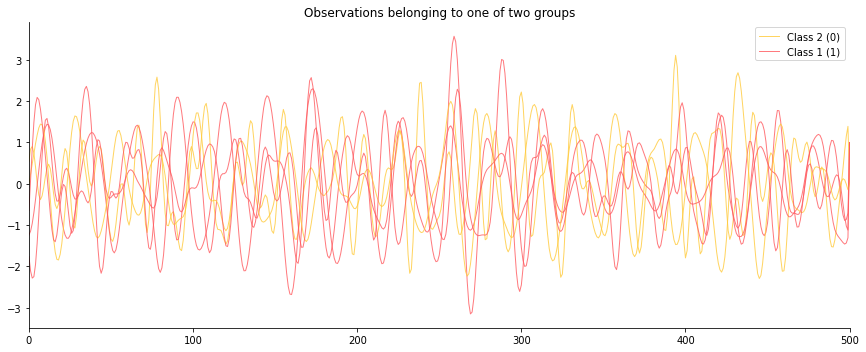

In [4]:
np.random.seed(42)

label_class_1 = "Class 1 (1)"
label_class_2 = "Class 2 (0)"

plt.figure(figsize=(12, 5))
plt.title("Observations belonging to one of two groups")
for i in np.random.randint(0, len(df), size=(5) ):
    if df.loc[i, "target"] == 1:
        color = colormap(0)
        label = label_class_1
    else:
        color = colormap(1)
        label = label_class_2
    
    plt.plot(df.values[i], color=color, alpha=0.8, label=label, linewidth=1)
    
    if label == label_class_1:
        label_class_1 = None
    if label == label_class_2:
        label_class_2 = None
    
plt.legend()
plt.tight_layout()
plt.xlim(0, 500)
plt.show()

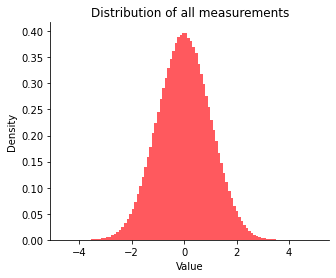

In [5]:
measurements = df.values[:, :-1].reshape((-1))

plt.figure(figsize=(5, 4))
plt.title("Distribution of all measurements")
plt.hist(measurements, bins=100, density=True)
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

### Preprocess data

In [6]:
X = torch.FloatTensor(df.drop("target", axis=1).values.reshape((len(df), 1, 1, -1)))
y = torch.FloatTensor(df["target"].values)#.reshape((-1, 1)))

train_size = 0.75
i = int(train_size * len(df))

X_train, y_train = X[:i], y[:i]
X_test, y_test = X[i:], y[i:]

In [7]:
class FordADataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        item = self.features[idx]
        label = self.target[idx]
        
        return item, label
    
train = FordADataset(X_train, y_train)
test = FordADataset(X_test, y_test)

train_loader = DataLoader(train, batch_size=32, shuffle=False)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

### Define model and train

Current Loss: train = 0.226, validation = 0.26): 100%|█████████████████████████████████| 20/20 [00:36<00:00,  1.84s/it]
C:\Users\A0663043\OneDrive - ArcelorMittal\Documents\Doktorat AGH\ML_CUDA\utils.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


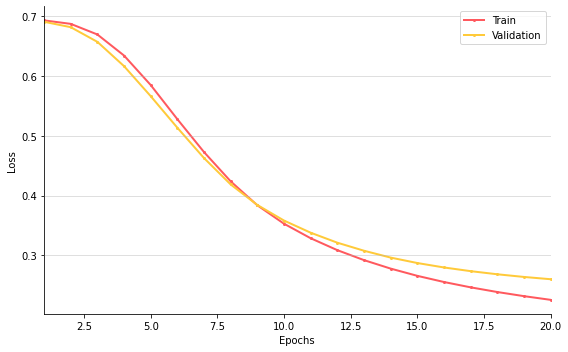

In [8]:
model = CNN(X.shape[1:])
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
loss_function = nn.BCELoss()

train_losses, valid_losses = cnn_learn.run_training(model, optimizer, loss_function, train_loader, test_loader, 20)
utils.plot_learning_curve(train_losses, valid_losses)

In [10]:
# determine accuracy

for name, Xi, yi in zip(["Train", "Test"], [X_train, X_test], [y_train, y_test]):
    y_pred = model(Xi).view(-1).detach().numpy().round().astype(int)
    acc = accuracy_score(yi, y_pred)
    print("%s accuracy: %.3g" % (name, (100 * acc)) + "%")

Train accuracy: 92.7%
Test accuracy: 90.1%


### Results visualization

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


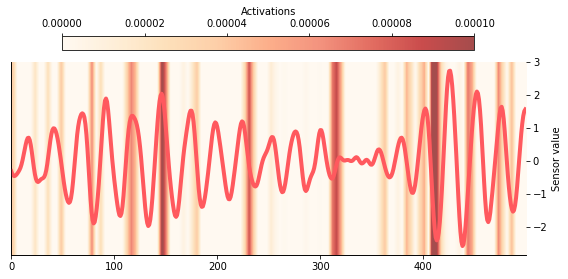

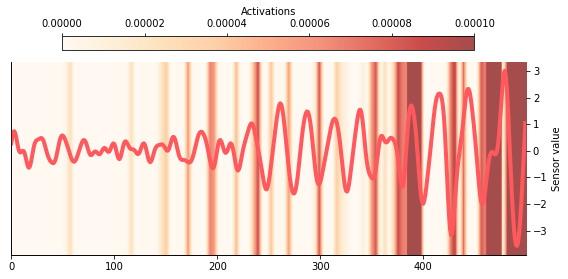

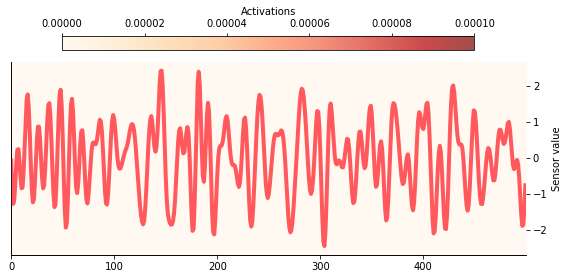

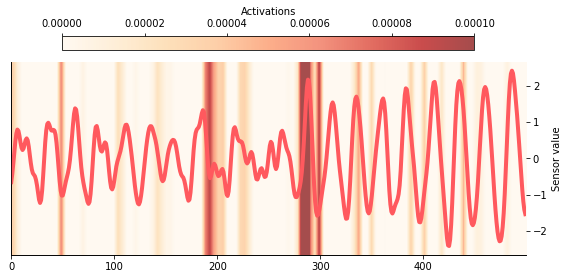

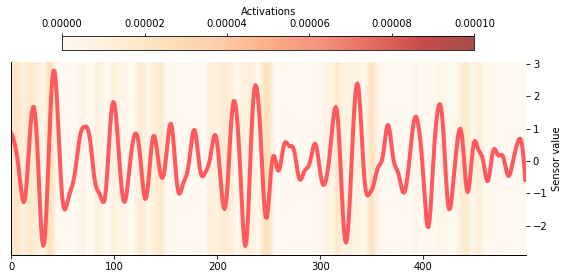

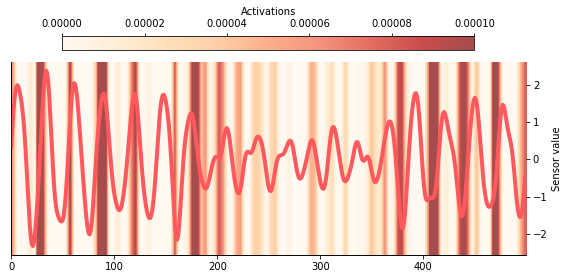

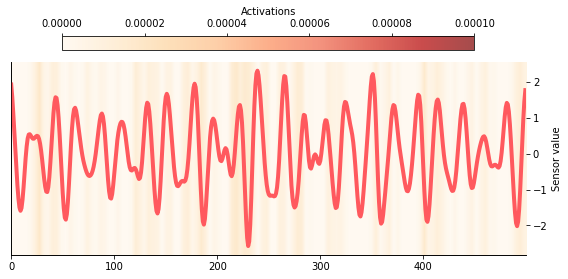

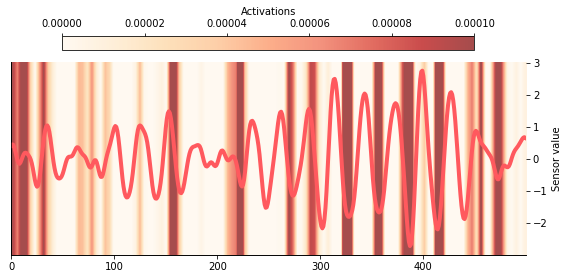

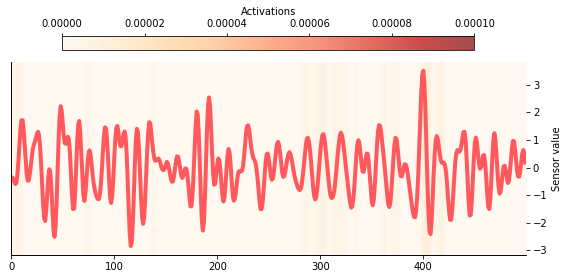

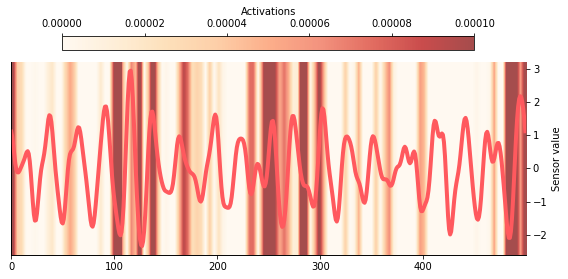

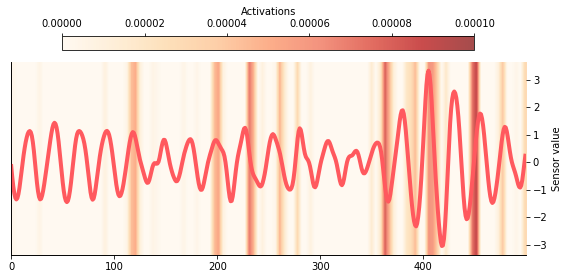

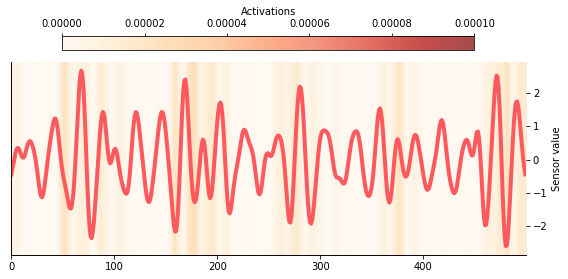

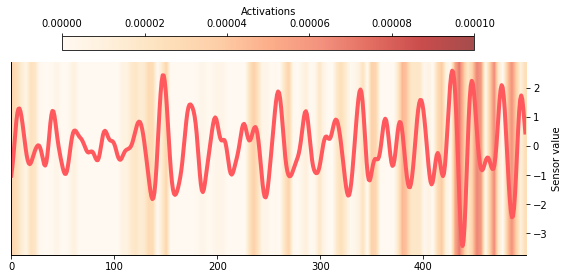

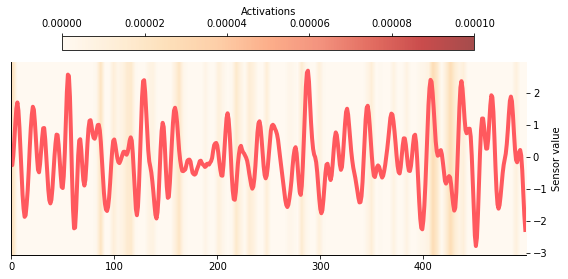

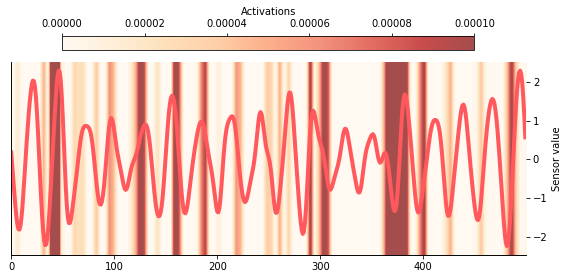

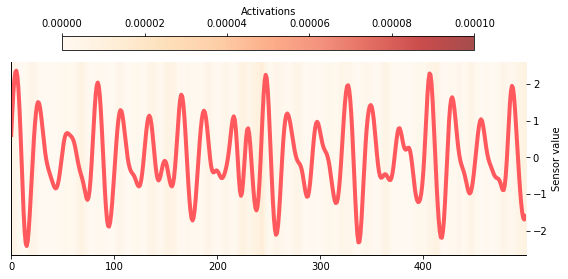

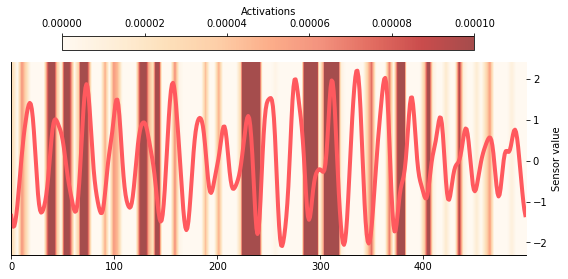

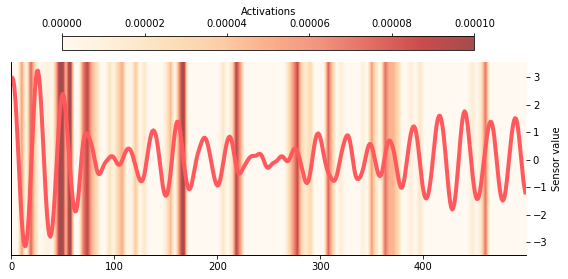

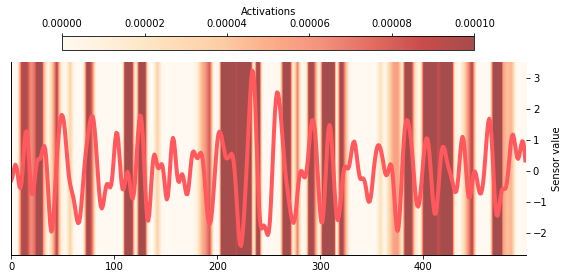

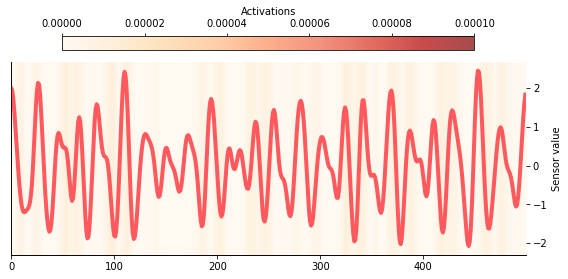

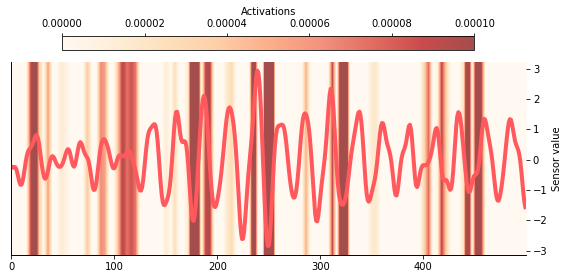

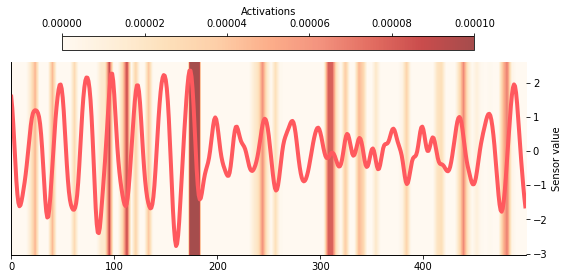

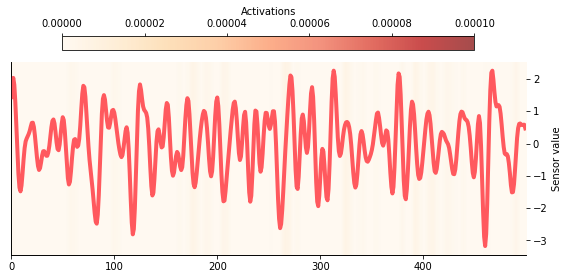

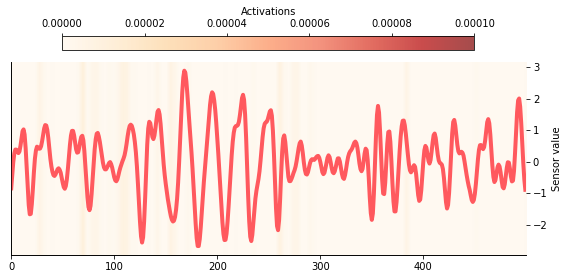

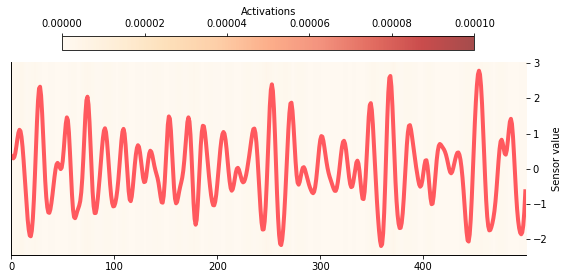

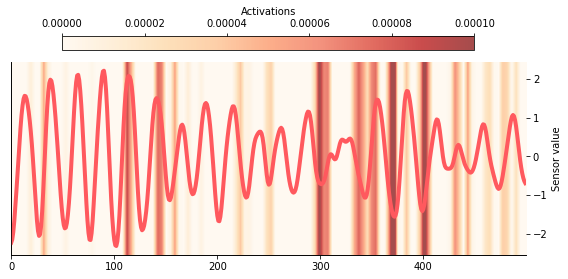

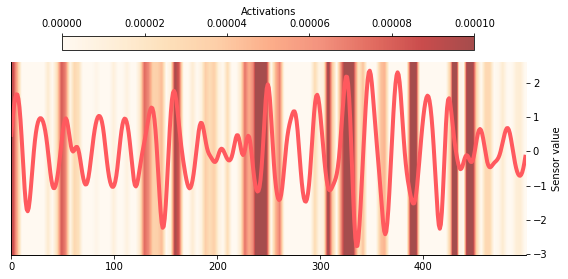

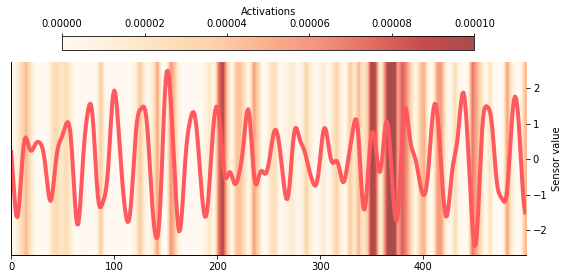

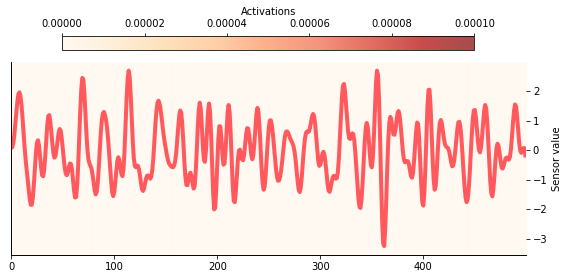

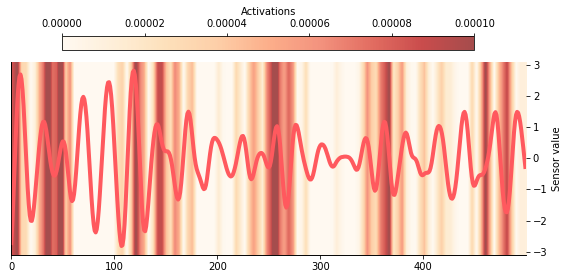

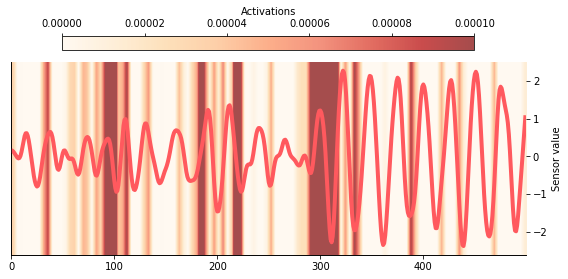

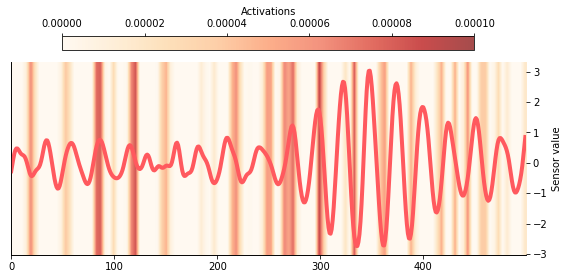

In [11]:
def reshape_transform(tensor, target_size):
    """ 
    Transforms a tensor to the required shape by interpolation
    Used to transform the tensor before last pooling layer to input size.
    Note: this should only interpolate time axis, not the feature axis!
    """
    if tensor.dim() == 1:
        tensor = tensor.reshape(1, -1)
    tensor = tensor.reshape((1, 1, tensor.shape[0], tensor.shape[1]))
    image_with_single_row = tensor[:, None, :, :]
    # Lets make the time series into an image with 16 rows for easier visualization on screen later
    return torch.nn.functional.interpolate(tensor, target_size, mode='bilinear')

def genereate_gradcam_explanation(model, x):
    pred = model.forward(x, cam=True)
    
    pred[0][0].backward()
    
    gradients = model.get_activations_gradient()    
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    
    # print("Pooled Gradients shape: {}".format(pooled_gradients.shape))
    
    activations = model.get_activations(x).detach()
    # print("Activations shape: {}".format(activations.shape))

    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    mean_activations = torch.mean(activations, dim=1).squeeze()
    mean_activations = torch.maximum(mean_activations, torch.tensor(0))
    mean_activations = reshape_transform(mean_activations, (x.shape[-2], x.shape[-1]))
    return mean_activations


def plot_explanation_heatmap(x, y, explanation):
    """
    Function to plot explanation heatmap
    """        
    t = explanation.shape[-1] -1 # time 
    x = x.reshape(1, -1)
    explanation = explanation.reshape(1, -1)

    fig, ax =plt.subplots(figsize=(8, 4))
    colormap_activations = ax.imshow(explanation, aspect=200, vmin=0, vmax=1e-4, cmap="OrRd", alpha=0.7)
    plt.colorbar(colormap_activations, shrink=0.8, label="Activations", location="top", aspect=30)
    plt.yticks([])
    plt.twinx()
    plt.plot(x.squeeze(), linewidth=4)
    plt.ylabel("Sensor value")
    plt.xlabel("Time")
    fig.tight_layout()
    
    
# batch of data for explanations
x_batch, y_batch = next(iter(test_loader))


for i in range(x_batch.shape[0]):
    x = x_batch[i:i+1]
    y = y_batch[i:i+1]

    explanation = genereate_gradcam_explanation(model, x)
    plot_explanation_heatmap(x, 0, explanation)